**Variable Screening and Transformation**

Goals:
- remove redundant covariates
- stabilize distributions
- produce a candidate set identical for all models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
df = pd.read_csv("/Users/inesschwartz/Desktop/training_data.csv")
df.head

<bound method NDFrame.head of      site_info_id  profile        X_coord       Y_coord      district  \
0            2139   100_56  637881.888723  8.608926e+06        Huambo   
1            1927   100_58  385725.693290  8.669325e+06      Benguela   
2              17   100_59  248538.636350  9.488118e+06       Cabinda   
3            1701   100_63  840008.131292  8.731220e+06       Malanje   
4            1934  101A_58  384135.495798  8.666721e+06      Benguela   
..            ...      ...            ...           ...           ...   
921          1689    99_63  845428.695068  8.739847e+06       Malanje   
922           348    9C_60  576475.085504  9.208450e+06  Uige e Zaire   
923          1213    9C_63  648834.637380  8.895791e+06       Malanje   
924          2928     9_62  673979.168557  8.495066e+06           Bie   
925           960     9_63  726015.143834  8.959163e+06       Malanje   

                                         geometry    year  faosoil_id  \
0      POINT (637881

In [3]:
# Drop the 'geometry' column
df = df.drop(columns=['geometry'])


In [4]:
print(df.X_coord.min(), df.X_coord.max())
print(df.Y_coord.min(), df.Y_coord.max())


174544.60741365992 1482544.1461838111
7998325.191518262 9508186.763478452


In [5]:
## outliers, 0s, nans

import pandas as pd
import numpy as np

# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Initialize results dictionary
summary = {}

for col in numeric_cols:
    data = df[col]
    
    # Count NaNs
    n_nan = data.isna().sum()
    
    # Count zeros
    n_zero = (data == 0).sum()
    
    # Detect outliers using 1.5*IQR rule
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    n_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    
    # Store results
    summary[col] = {
        "NaN_count": n_nan,
        "Zero_count": n_zero,
        "Outlier_count": n_outliers
    }

# Convert results to a DataFrame for easy viewing
summary_df = pd.DataFrame(summary).T  # transpose for readability
summary_df = summary_df.sort_values(by="Outlier_count", ascending=False)

# Display results
print(summary_df)


                           NaN_count  Zero_count  Outlier_count
formation                          0           1            256
flowline_curve                     4           0            229
precip_driest_month               25         756            145
litho_value                        0           7            119
landsurface_value                  0           7            116
...                              ...         ...            ...
MRVBF                              4           0              0
MRRTF                              4           0              0
mean_temp_coldest_quarter         25           0              0
tmin_mean_mean                    24           0              0
site_info_id                       0           0              0

[86 rows x 3 columns]


/opt/homebrew/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(summary_df)


                           NaN_count  Zero_count  Outlier_count
formation                          0           1            256
flowline_curve                     4           0            229
precip_driest_month               25         756            145
litho_value                        0           7            119
landsurface_value                  0           7            116
total_curve                        4           0            107
profile_curve                      4           0            105
plan_curve                         4           0             98
rf_norice_1960                    18          60             95
tot_rainfed_1960                  18          60             95
rf_norice_1950                    18          80             94
precip_driest_quarter             25         176             94
cropland_1950                     18          75             93
tot_rainfed_1950                  18          80             93
flow_accumulation                  0    

In [7]:
# Count rows where the target is NaN
missing_target_count = df['log_soc_stock'].isna().sum()

print(f"Number of rows with missing target (log_soc_stock): {missing_target_count}")


Number of rows with missing target (log_soc_stock): 0


In [8]:
## imputing missing values using simpleimpute 

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# --------------------------
# Parameters
# --------------------------
row_nan_threshold = 0.2   # Drop rows with >20% missing predictors
col_nan_threshold = 0.5   # Drop predictors with >50% missing values
impute_strategy = 'median'  # 'median' or 'mean'
placeholder_values = [-9999, -9999.0, np.inf, -np.inf]  # values to treat as NaN
target_col = 'log_soc_stock'  # target variable

# --------------------------
# Copy original DataFrame
# --------------------------
df_cleaned = df.copy()

# --------------------------
# Step 0: Replace invalid placeholder values with NaN
# --------------------------
df_cleaned.replace(placeholder_values, np.nan, inplace=True)

# --------------------------
# Step 1: Identify numeric predictors (exclude target)
# --------------------------
predictor_cols = df_cleaned.select_dtypes(include='number').columns.drop(target_col)

# --------------------------
# Step 2: Remove columns with too many NaNs
# --------------------------
missing_pct_cols = df_cleaned[predictor_cols].isna().mean()
cols_to_keep = missing_pct_cols[missing_pct_cols <= col_nan_threshold].index
cols_dropped = missing_pct_cols[missing_pct_cols > col_nan_threshold].index

df_cleaned = df_cleaned[[target_col] + list(cols_to_keep)].copy()

# --------------------------
# Step 3: Remove rows with too many NaNs
# --------------------------
predictor_cols_cleaned = cols_to_keep  # updated predictor columns
max_missing_per_row = int(row_nan_threshold * len(predictor_cols_cleaned))
rows_missing_count = df_cleaned[predictor_cols_cleaned].isna().sum(axis=1)
rows_to_keep = rows_missing_count <= max_missing_per_row
rows_dropped_count = (~rows_to_keep).sum()

df_cleaned = df_cleaned[rows_to_keep].copy()

# --------------------------
# Step 4: Impute remaining missing predictor values
# --------------------------
imputer = SimpleImputer(strategy=impute_strategy)
n_missing_before = df_cleaned[predictor_cols_cleaned].isna().sum().sum()

df_cleaned[predictor_cols_cleaned] = imputer.fit_transform(df_cleaned[predictor_cols_cleaned])

n_missing_after = df_cleaned[predictor_cols_cleaned].isna().sum().sum()
n_imputed = n_missing_before - n_missing_after

# --------------------------
# Step 5: Summary report
# --------------------------
print("✅ Data cleaning summary report")
print("---------------------------------")
print(f"Original rows: {len(df)}")
print(f"Original predictor columns: {len(predictor_cols)}")
print(f"Columns dropped due to >{col_nan_threshold*100:.0f}% NaNs: {len(cols_dropped)}")
if len(cols_dropped) > 0:
    print("Dropped columns:", list(cols_dropped))
print(f"Rows dropped due to >{row_nan_threshold*100:.0f}% missing predictors: {rows_dropped_count}")
print(f"Remaining rows: {len(df_cleaned)}")
print(f"Remaining predictor columns: {len(predictor_cols_cleaned)}")
print(f"Missing predictor values imputed: {n_imputed}")


✅ Data cleaning summary report
---------------------------------
Original rows: 926
Original predictor columns: 85
Columns dropped due to >50% NaNs: 0
Rows dropped due to >20% missing predictors: 19
Remaining rows: 907
Remaining predictor columns: 85
Missing predictor values imputed: 559


In [9]:
# Ensure 'year' column exists
if 'year' in df_cleaned.columns:
    min_year = df_cleaned['year'].min()
    max_year = df_cleaned['year'].max()
    print(f"The year range in df is: {min_year} – {max_year}")
else:
    print("Column 'year' does not exist in df.")


The year range in df is: 1946.0 – 1967.0


In [10]:
# After SimpleImputer (end of cleaning section)
df_cleaned1 = df_cleaned

In [11]:
## looking for perfectly correlated, constant columns (have same info)

import numpy as np
import pandas as pd

# Drop columns with a single unique value
constant_cols = [c for c in df.columns if df[c].nunique() <= 1]
df_reduced = df_cleaned1.drop(columns=constant_cols)

# Compute correlation matrix (absolute values)
corr_matrix = df_reduced.corr(numeric_only=True).abs()

# Get upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find all pairs that are perfectly correlated (|r| = 1.0)
perfect_corr_pairs = [
    (col1, col2)
    for col1 in upper.columns
    for col2 in upper.index
    if upper.loc[col2, col1] == 1.0
]

# Print results
print("Constant columns:", constant_cols)
if perfect_corr_pairs:
    print("\nPerfectly correlated column pairs (|r| = 1.0):")
    for col1, col2 in perfect_corr_pairs:
        print(f"  {col1} ↔ {col2}")
else:
    print("\nNo perfectly correlated column pairs found.")


Constant columns: []

Perfectly correlated column pairs (|r| = 1.0):
  max_temp_warmest_month ↔ annual_mean_temp
  mean_temp_driest_quarter ↔ annual_mean_temp
  mean_temp_driest_quarter ↔ max_temp_warmest_month
  mean_temp_warmest_quarter ↔ annual_mean_temp
  mean_temp_warmest_quarter ↔ max_temp_warmest_month
  mean_temp_warmest_quarter ↔ mean_temp_driest_quarter
  mean_temp_wettest_quarter ↔ annual_mean_temp
  mean_temp_wettest_quarter ↔ max_temp_warmest_month
  mean_temp_wettest_quarter ↔ mean_temp_driest_quarter
  mean_temp_wettest_quarter ↔ mean_temp_warmest_quarter
  min_temp_coldest_month ↔ annual_mean_temp
  min_temp_coldest_month ↔ max_temp_warmest_month
  min_temp_coldest_month ↔ mean_temp_driest_quarter
  min_temp_coldest_month ↔ mean_temp_warmest_quarter
  min_temp_coldest_month ↔ mean_temp_wettest_quarter
  temp_annual_range ↔ annual_mean_temp
  temp_annual_range ↔ max_temp_warmest_month
  temp_annual_range ↔ mean_temp_driest_quarter
  temp_annual_range ↔ mean_temp_warmest_

In [12]:
## drop redundant columns except what FAO wants (seasonality, annual mean temp, temp annual range)

import pandas as pd
import numpy as np
from collections import defaultdict

# Columns you want to retain even if flagged as perfectly correlated
keep_cols = [
    "annual_mean_temp",
    "temp_annual_range",
    "temp_seasonality",
    "temp_annual_range"
]

# --- Step 1: Remove constant columns (optional, helps with NaNs) ---
constant_cols = [c for c in df_cleaned.columns if df_cleaned[c].nunique() <= 1]
df_reduced = df_cleaned.drop(columns=constant_cols)
print("Constant columns:", constant_cols)

# --- Step 2: Compute correlation matrix ---
corr_matrix = df_reduced.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# --- Step 3: Find perfectly correlated pairs ---
perfect_corr_pairs = [
    (col1, col2)
    for col1 in upper.columns
    for col2 in upper.index
    if upper.loc[col2, col1] == 1.0
]

# --- Step 4: Group them into clusters of identical columns ---
groups = defaultdict(set)
for a, b in perfect_corr_pairs:
    groups[a].add(a)
    groups[a].add(b)

merged_groups = []
for g in groups.values():
    merged = False
    for mg in merged_groups:
        if not g.isdisjoint(mg):
            mg.update(g)
            merged = True
            break
    if not merged:
        merged_groups.append(g)

# --- Step 5: Respect keep_cols and show grouped results ---
if merged_groups:
    print("\nPerfectly correlated variable groups (|r|=1.0):\n")
    for i, g in enumerate(merged_groups, 1):
        kept = [col for col in g if col in keep_cols]
        others = [col for col in g if col not in keep_cols]
        print(f"Group {i}: {', '.join(sorted(g))}")
        if kept:
            print(f"  ✅ Keeping: {', '.join(kept)}")
        if others:
            print(f"  ⚠️  Other redundant: {', '.join(others)}")
        print()
else:
    print("No perfectly correlated groups found.")


Constant columns: []

Perfectly correlated variable groups (|r|=1.0):

Group 1: annual_mean_temp, max_temp_warmest_month, mean_temp_driest_quarter, mean_temp_warmest_quarter, mean_temp_wettest_quarter, min_temp_coldest_month, temp_annual_range, temp_seasonality
  ✅ Keeping: annual_mean_temp, temp_seasonality, temp_annual_range
  ⚠️  Other redundant: mean_temp_warmest_quarter, mean_temp_driest_quarter, max_temp_warmest_month, min_temp_coldest_month, mean_temp_wettest_quarter



In [13]:
# ----------------------------
# 2. Numeric columns
# ----------------------------
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns

# ----------------------------
# 3. Output folder
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/training_eda_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------
# 4. Plot histograms in a grid
# ----------------------------
n_cols = 4  # columns in grid
n_rows = int(np.ceil(len(numeric_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color="steelblue")
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(out_dir / "histograms_grid.png", dpi=150)
plt.close()
print(f"Histograms saved to: {out_dir}")

Histograms saved to: /Users/inesschwartz/Desktop/training_eda_histograms


In [14]:
df_reduced.columns

Index(['log_soc_stock', 'site_info_id', 'X_coord', 'Y_coord', 'year',
       'faosoil_id', 'landsurface_value', 'litho_value', 'formation',
       'conv_rangeland_1950', 'conv_rangeland_1960', 'cropland_1950',
       'cropland_1960', 'grazing_1950', 'grazing_1960', 'ir_norice_1950',
       'ir_norice_1960', 'ir_rice_1950', 'ir_rice_1960', 'pasture_1950',
       'pasture_1960', 'rangeland_1950', 'rangeland_1960', 'rf_norice_1950',
       'rf_norice_1960', 'rf_rice_1950', 'rf_rice_1960', 'tot_irri_1950',
       'tot_irri_1960', 'tot_rainfed_1950', 'tot_rainfed_1960',
       'tot_rice_1950', 'tot_rice_1960', 'mean_temp_coldest_quarter',
       'annual_mean_temp', 'annual_precip', 'isothermality',
       'max_temp_warmest_month', 'mean_temp_driest_quarter',
       'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter',
       'min_temp_coldest_month', 'precip_coldest_quarter',
       'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
       'precip_warmest_quarter', 'p

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

df_reduced

# ----------------------------
# 2. List topographic / DEM-derived columns
# ----------------------------
topo_cols = [
    "MRVBF",
    "MRRTF",
    "aspect",
    "aspect_cos",
    "aspect_sin",
    "dem_1km_utm33s",
    "hillshade",
    "hillslope_index",
    "length_slope_factor",
    "max_curve",
    "profile_curve",
    "relief_TRI",
    "slope",
    "slope_height",
    "slope_length",
    "total_curve",
    "twi",
    "valley_depth",
    "valley_index",
    "watershed_basins",
    "flow_accumulation",
    "flow_directions"
]

# ---------------------------- Already taken care of using median imputing
# # 3. Replace known NoData placeholders with NaN
# # ----------------------------
# nodata_values = [-99999, -9999, -999, 99999, 9999]  # extend if needed
# for col in topo_cols:
#     df_reduced[col] = df_reduced[col].replace(nodata_values, np.nan)

# ----------------------------
# 4. Clip outliers based on percentiles
# ----------------------------
def clip_outliers(series, lower_pct=1, upper_pct=99):
    lower = np.percentile(series.dropna(), lower_pct)
    upper = np.percentile(series.dropna(), upper_pct)
    return series.clip(lower, upper)

for col in topo_cols:
    df_reduced[col] = clip_outliers(df_reduced[col], lower_pct=1, upper_pct=99)

# # ----------------------------
# # 5. Optional: plot histograms after clipping
# # ----------------------------
# out_dir = Path("/Users/inesschwartz/Desktop/topo_histograms")
# out_dir.mkdir(parents=True, exist_ok=True)

# for col in topo_cols:
#     plt.figure(figsize=(5,4))
#     sns.histplot(df[col].dropna(), bins=30, kde=True, color='steelblue')
#     plt.title(f"Histogram of {col} (clipped)")
#     plt.xlabel(col)
#     plt.ylabel("Count")
#     plt.tight_layout()
#     plt.savefig(out_dir / f"hist_{col}.png", dpi=150)
#     plt.close()

# print(f"Clipping done. Histograms saved in: {out_dir}")

# # ----------------------------
# # 6. Save cleaned dataset  After topo cleaning/clipping
# df_reduced.to_csv("/Users/inesschwartz/Desktop/training_data_topo_cleaned.csv", index=False)

In [16]:
df_reduced[numeric_cols].skew().sort_values(ascending=False)


rf_rice_1950                 30.116441
rf_rice_1960                 30.116441
ir_norice_1960               30.116441
hill_height                  29.894946
ir_norice_1950               23.902602
                               ...    
mean_temp_wettest_quarter    -7.874415
max_temp_warmest_month       -7.874415
annual_mean_temp             -7.874415
mean_temp_warmest_quarter    -7.874415
plan_curve                   -7.908128
Length: 86, dtype: float64

In [17]:
df_reduced.head(5)

log_soc_stock  site_info_id        X_coord       Y_coord    year  \
0       1.260593        2139.0  637881.888723  8.608926e+06  1956.0   
1       1.659299        1927.0  385725.693290  8.669325e+06  1958.0   
2       0.000000          17.0  248538.636350  9.488118e+06  1959.0   
3       0.972043        1701.0  840008.131292  8.731220e+06  1963.0   
4       1.333861        1934.0  384135.495798  8.666721e+06  1958.0   

   faosoil_id  landsurface_value  litho_value  formation  conv_rangeland_1950  \
0        43.0                2.0          2.0       97.0              0.00000   
1       120.0                2.0          2.0      123.0              0.00000   
2         8.0                2.0          2.0       66.0             17.13189   
3        40.0                1.0          1.0       96.0              0.00000   
4       120.0                2.0          2.0      123.0              0.00000   

   ...  slope_height  slope_length  standardized_height  \
0  ...     79.743690   3000.000000           952.486816   
1  ...    209.757782   3414.213623            50.189114   
2  ...    167.649002      0.000000            72.041985   
3  ...     92.101753   4828.427246           509.570862   
4  ...    229.889511      0.000000            69.800308   

   terrain_surf_convexity  terrain_surf_texture   total_curve       twi  \
0               49.512749             77.167595  1.178243e-09  5.827370   
1               43.616150             72.120461  8.122644e-10  8.748525   
2               39.723015             71.185776  4.263759e-10  5.255396   
3               44.910591             72.663414  2.168373e-10  7.329942   
4               45.813786             71.682632  2.845996e-10  5.050433   

   valley_depth  valley_index  watershed_basins  
0     64.605621           0.0            4340.0  
1    502.267820           0.0            3570.0  
2    260.212341           0.0            7588.0  
3    111.684311           0.0            5267.0  
4    502.267820           0.0            3570.0  

[5 rows x 86 columns]

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# # ----------------------------
# # 1. Load training data
# # ----------------------------
# csv_path = "/Users/inesschwartz/Desktop/training_data_topo_cleaned.csv"
# df1 = pd.read_csv(csv_path)

# load data
df1 = df_reduced

# ----------------------------
# 2. List bioclimatic variables
# ----------------------------
bioclim_cols = [
    'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
    'isothermality', 'precip_coldest_quarter',
    'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
    'precip_warmest_quarter', 'precip_wettest_month',
    'precip_wettest_quarter', 'temp_annual_range',
    'temp_seasonality', 'tmin_mean_mean', 'tmax_mean_mean', 'precip_sum'
]

# ----------------------------
# 3. Replace extreme placeholder values with NaN
# ----------------------------
# thresholds based on plausible ranges for temperature (°C) and precipitation (mm)
for col in bioclim_cols:
    df1[col] = df1[col].apply(lambda x: np.nan if x < -1e5 or x > 1e5 else x)

# ----------------------------
# 4. Function for percentile-based clipping
# ----------------------------
def clip_percentiles(series, lower=1, upper=99):
    series_clean = series.dropna()
    lower_val, upper_val = np.percentile(series_clean, [lower, upper])
    return series.clip(lower_val, upper_val)

# ----------------------------
# 5. Plot and save histograms
# ----------------------------
out_dir = Path("/Users/inesschwartz/Desktop/bioclim_histograms")
out_dir.mkdir(parents=True, exist_ok=True)

for col in bioclim_cols:
    clipped = clip_percentiles(df1[col])
    plt.figure(figsize=(5,4))
    sns.histplot(clipped, bins=30, kde=True, color='darkgreen')
    plt.title(f"Histogram of {col} (clipped 1-99%)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(out_dir / f"hist_{col}.png", dpi=150)
    plt.close()

print(f"Bioclimatic histograms saved in: {out_dir}")

# ----------------------------
# 6. Save cleaned dataset
# ----------------------------
clean_csv_path = "/Users/inesschwartz/Desktop/training_data_bioclim_cleaned.csv"
df1.to_csv(clean_csv_path, index=False)
print(f"Cleaned bioclim dataset saved: {clean_csv_path}")


Bioclimatic histograms saved in: /Users/inesschwartz/Desktop/bioclim_histograms
Cleaned bioclim dataset saved: /Users/inesschwartz/Desktop/training_data_bioclim_cleaned.csv


In [19]:
df1.columns

Index(['log_soc_stock', 'site_info_id', 'X_coord', 'Y_coord', 'year',
       'faosoil_id', 'landsurface_value', 'litho_value', 'formation',
       'conv_rangeland_1950', 'conv_rangeland_1960', 'cropland_1950',
       'cropland_1960', 'grazing_1950', 'grazing_1960', 'ir_norice_1950',
       'ir_norice_1960', 'ir_rice_1950', 'ir_rice_1960', 'pasture_1950',
       'pasture_1960', 'rangeland_1950', 'rangeland_1960', 'rf_norice_1950',
       'rf_norice_1960', 'rf_rice_1950', 'rf_rice_1960', 'tot_irri_1950',
       'tot_irri_1960', 'tot_rainfed_1950', 'tot_rainfed_1960',
       'tot_rice_1950', 'tot_rice_1960', 'mean_temp_coldest_quarter',
       'annual_mean_temp', 'annual_precip', 'isothermality',
       'max_temp_warmest_month', 'mean_temp_driest_quarter',
       'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter',
       'min_temp_coldest_month', 'precip_coldest_quarter',
       'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
       'precip_warmest_quarter', 'p

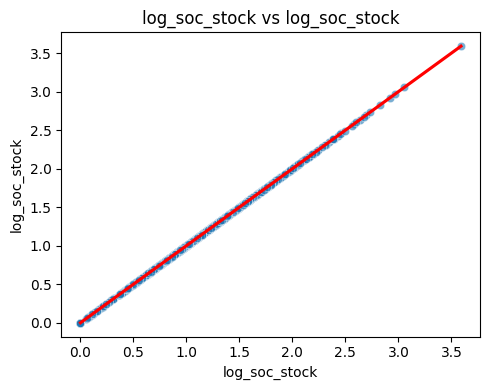

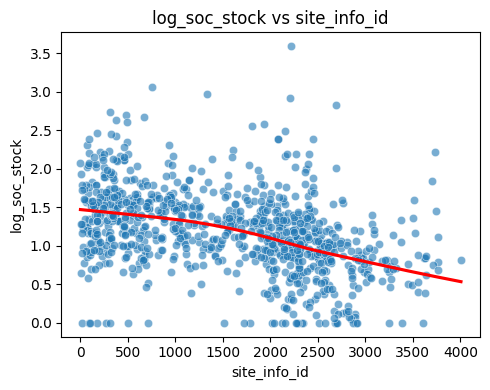

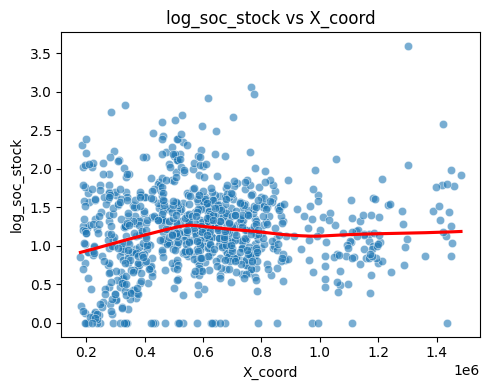

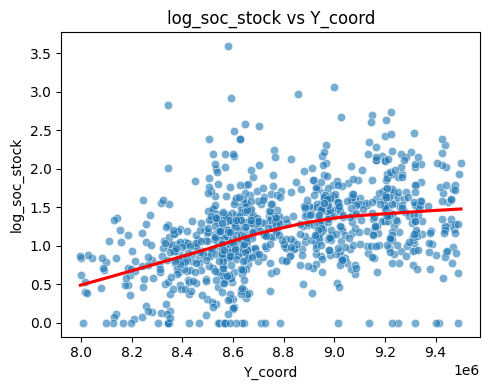

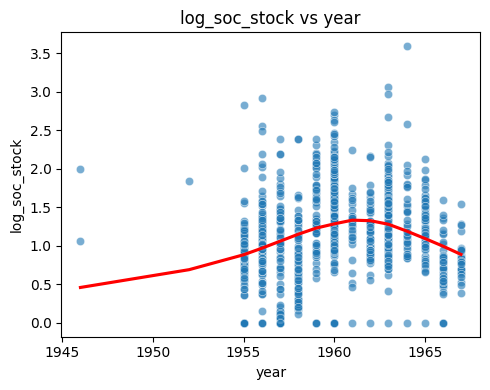

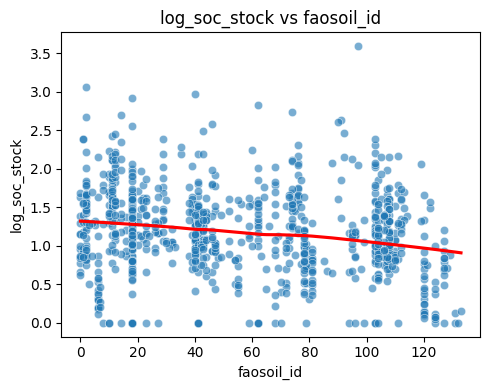

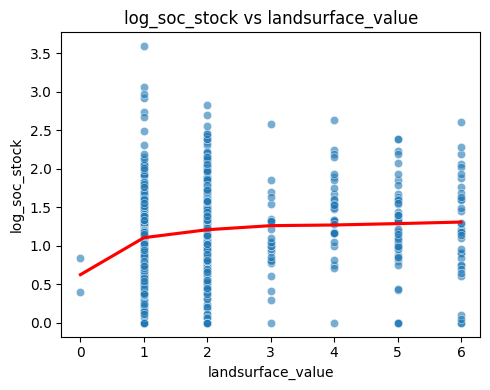

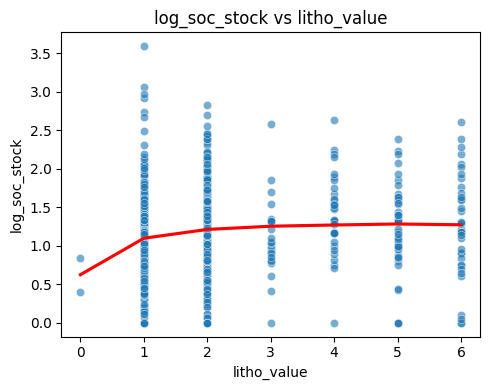

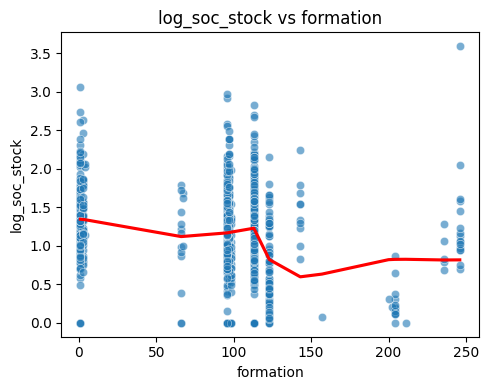

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


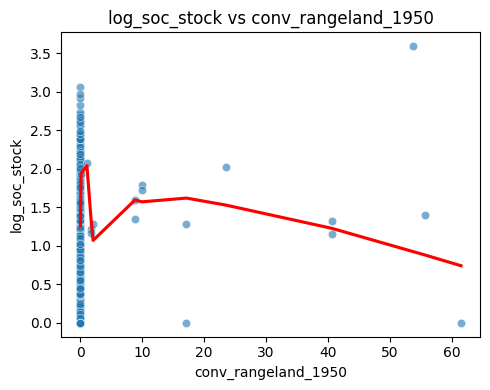

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


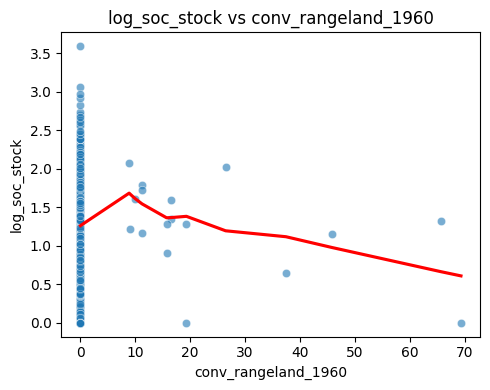

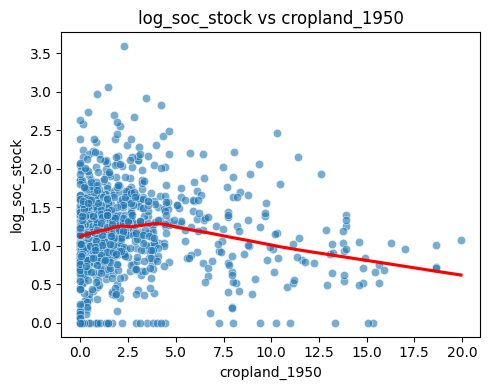

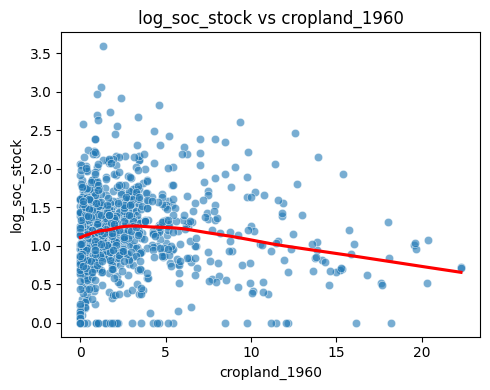

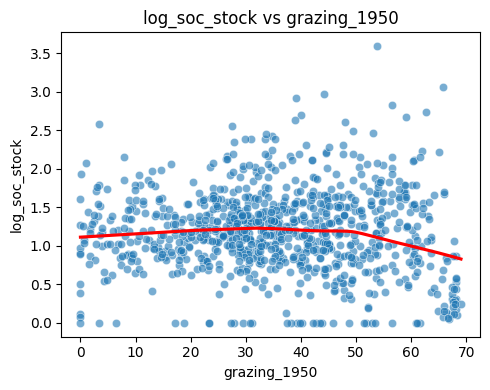

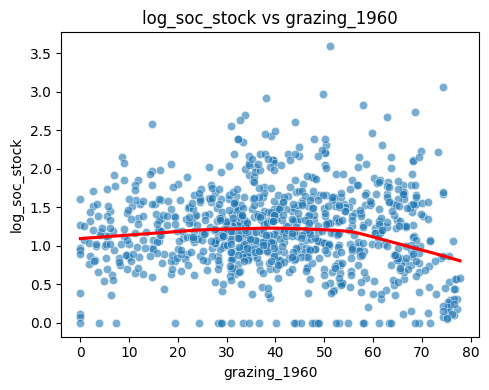

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


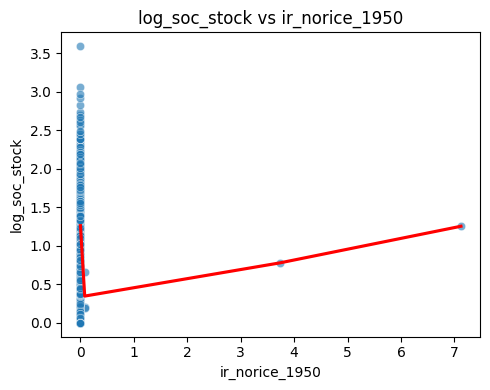

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


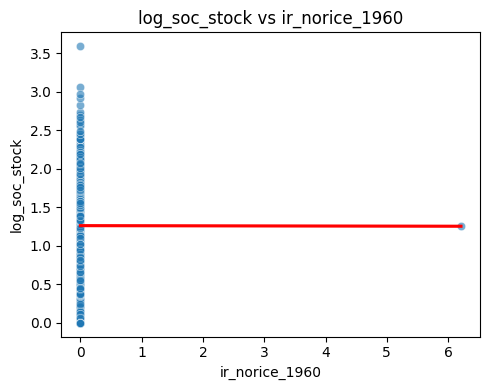

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


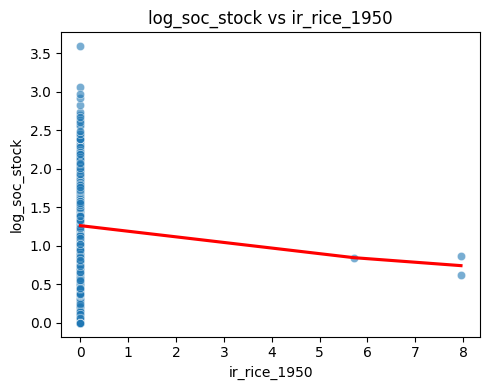

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


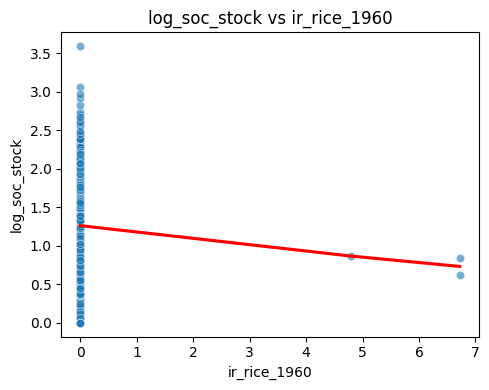

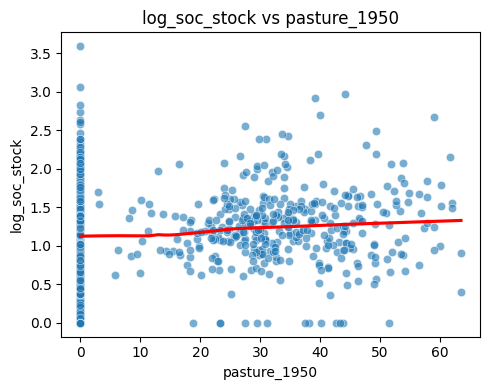

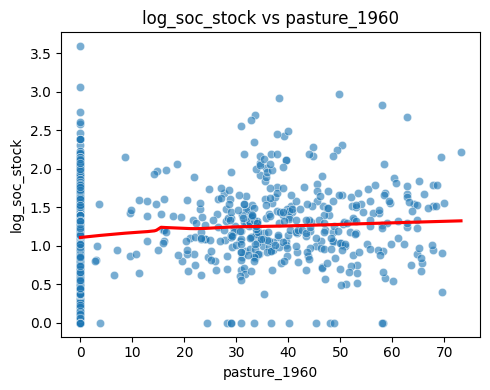

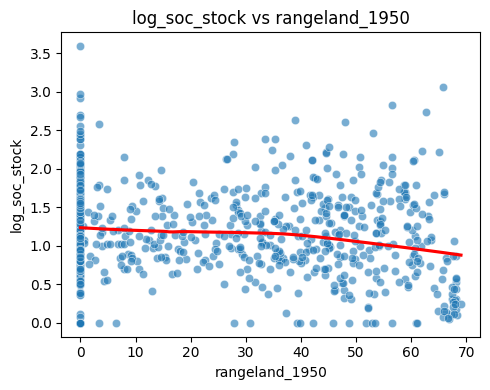

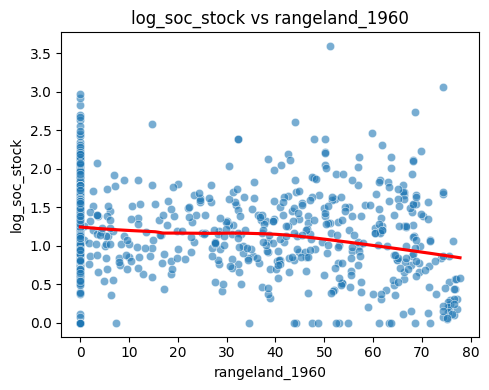

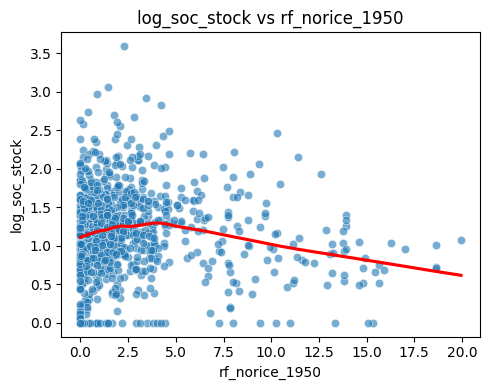

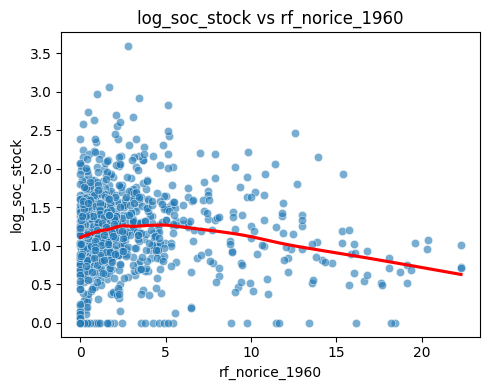

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


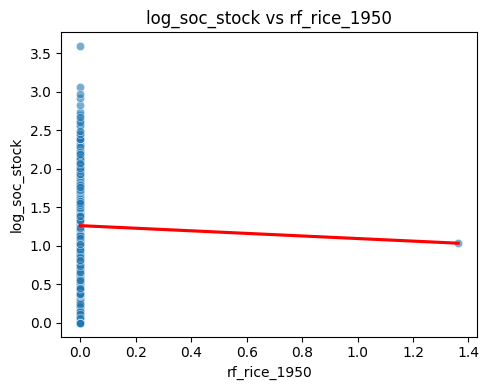

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


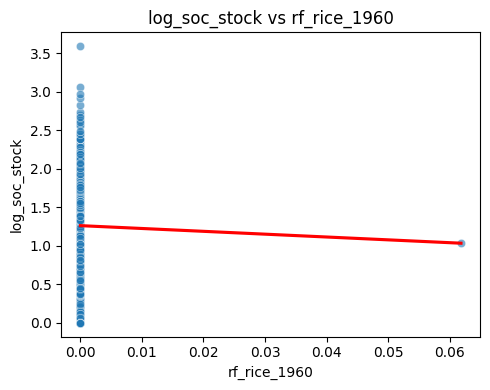

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


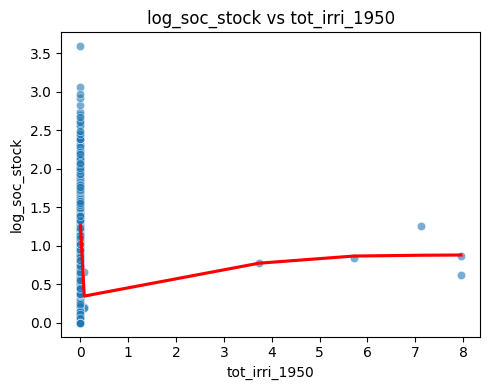

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


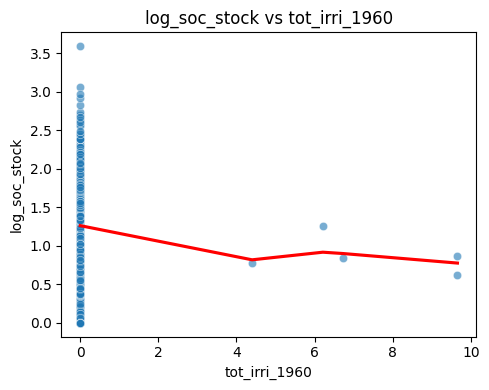

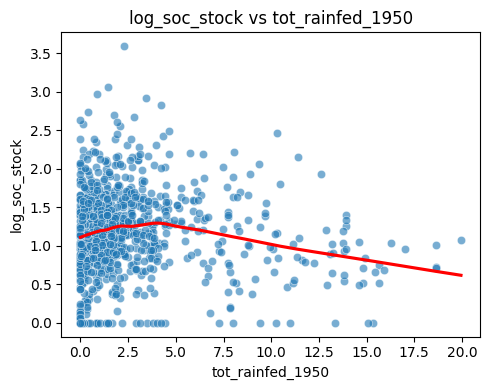

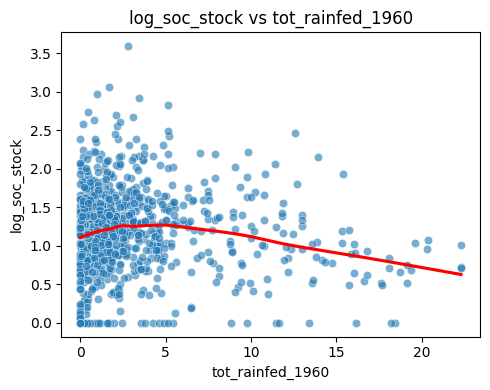

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


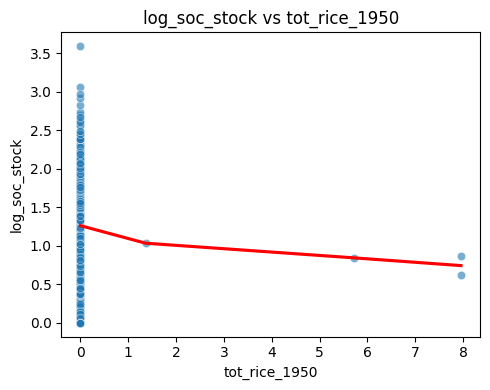

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


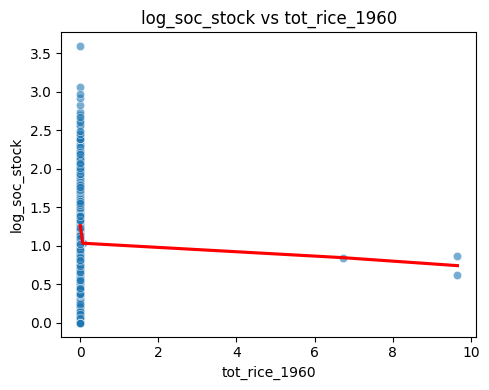

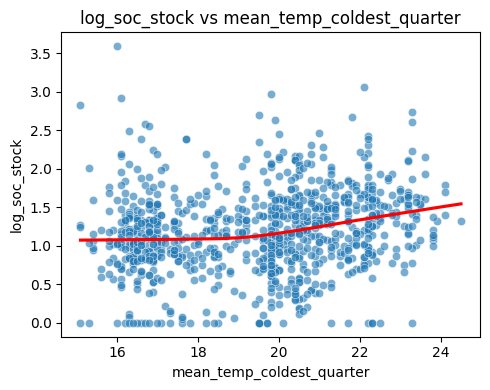

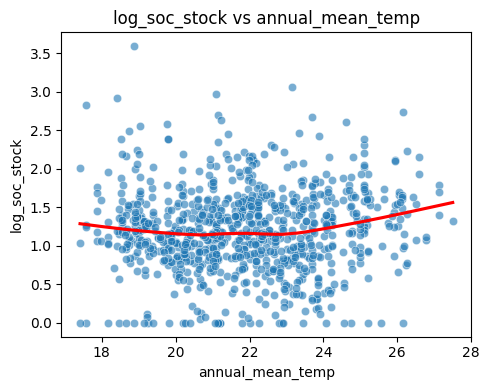

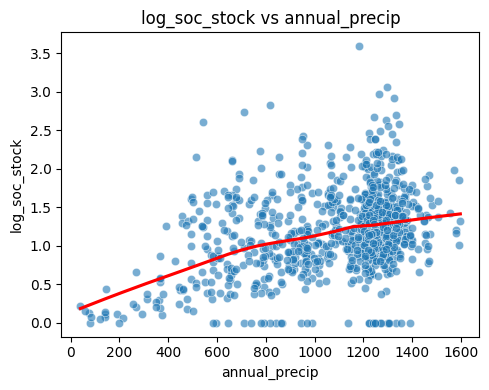

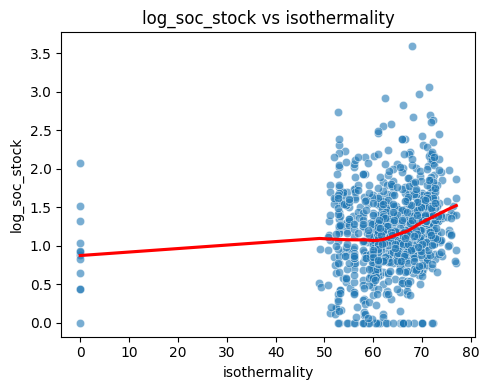

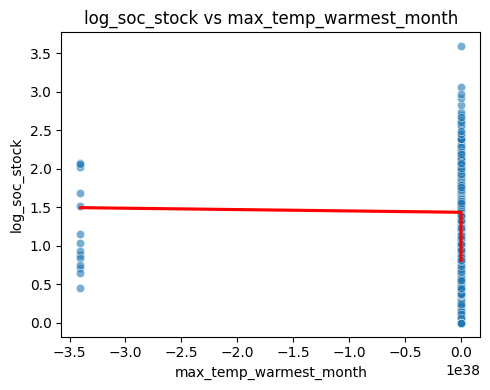

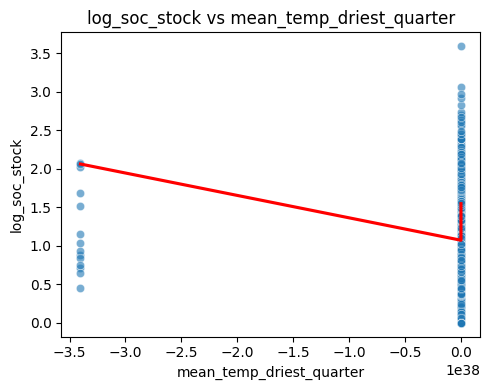

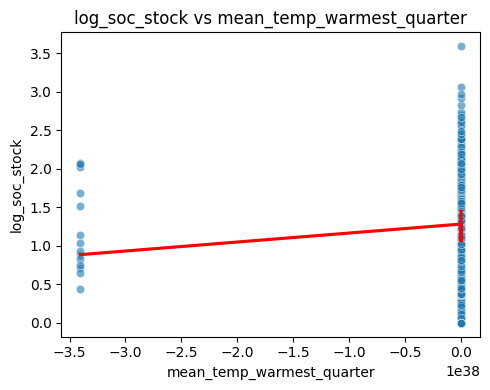

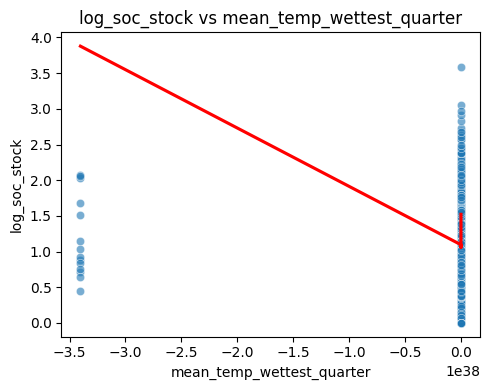

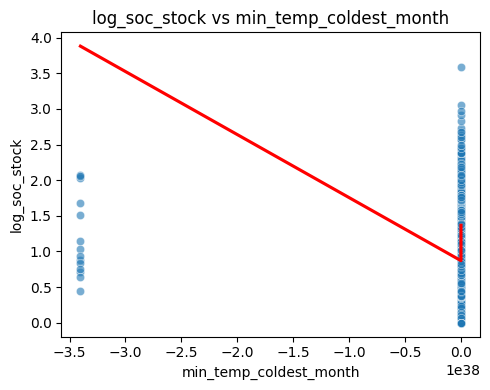

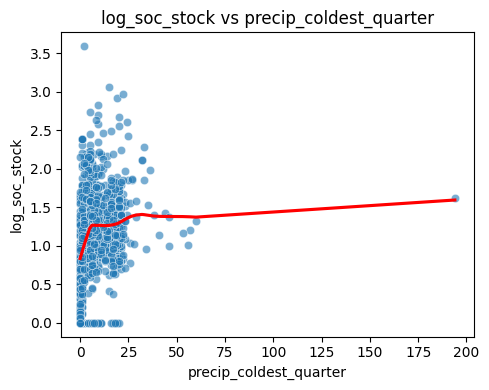

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


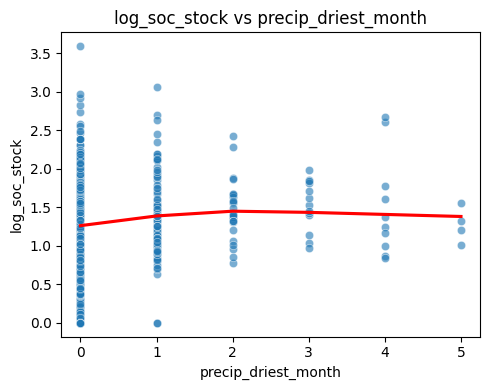

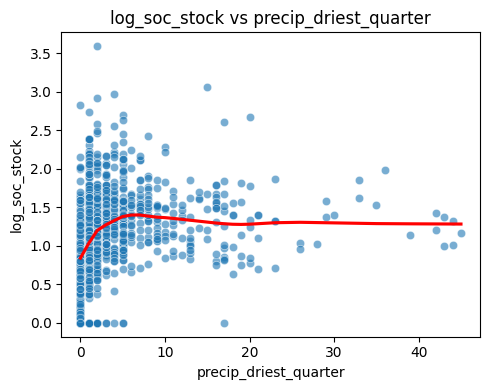

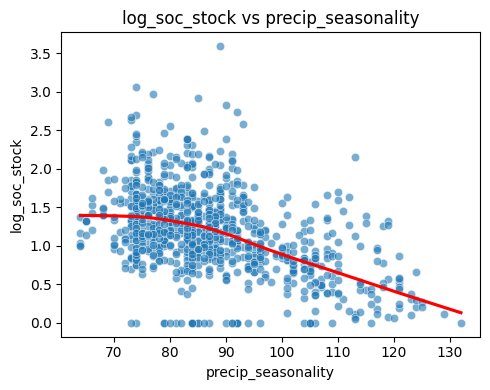

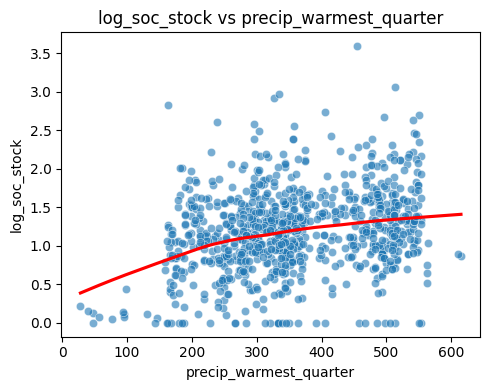

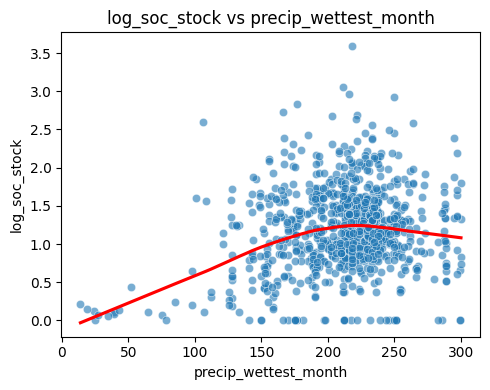

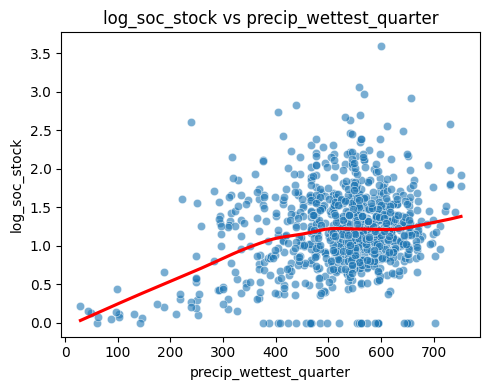

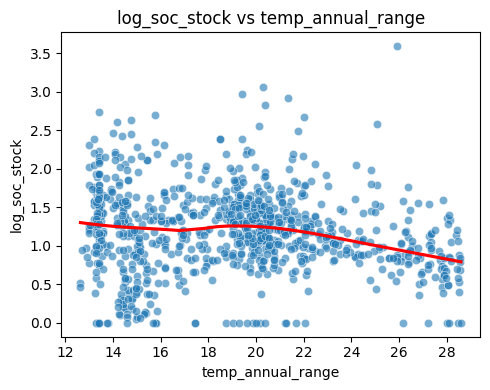

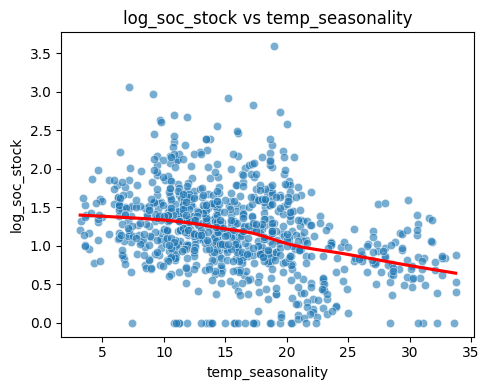

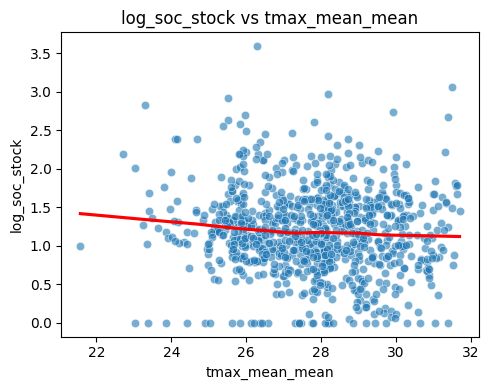

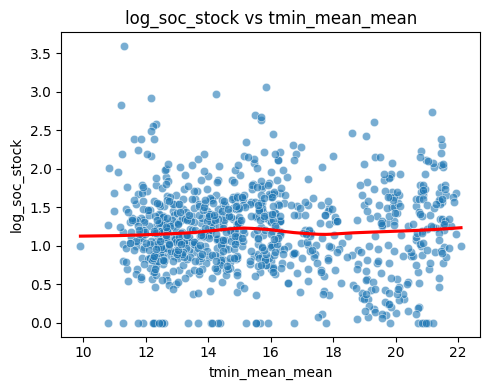

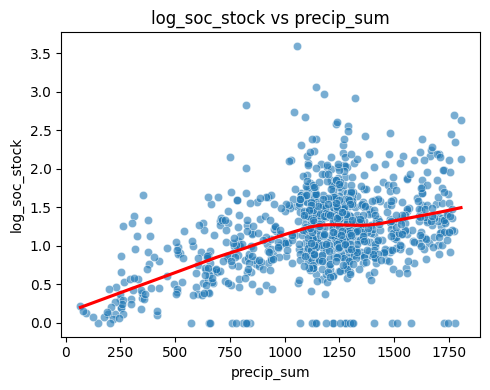

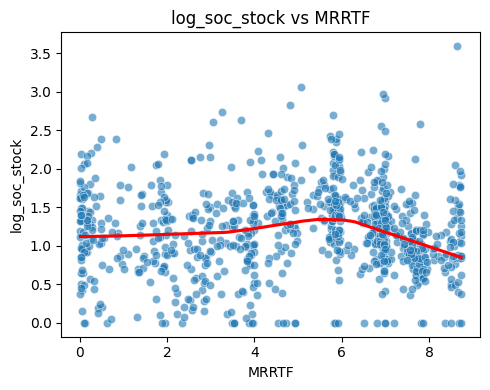

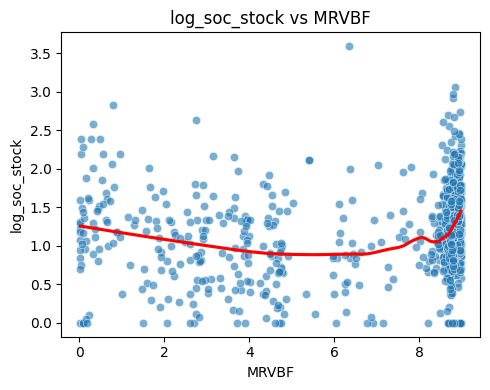

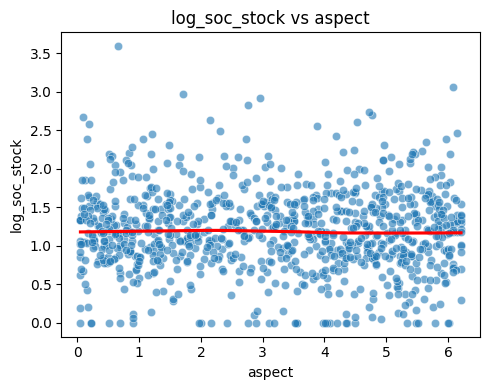

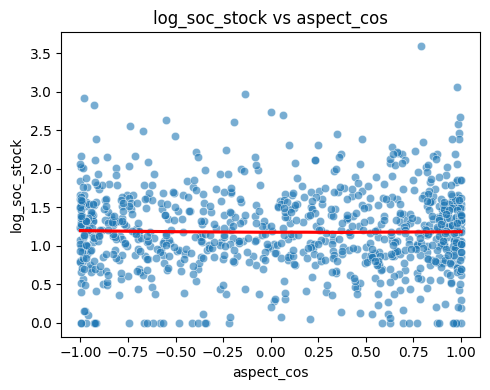

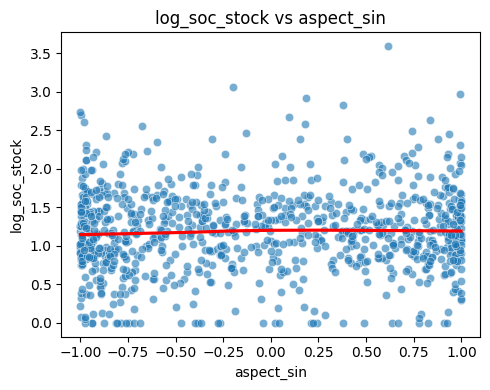

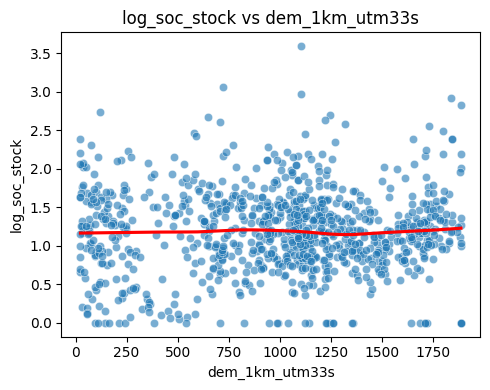

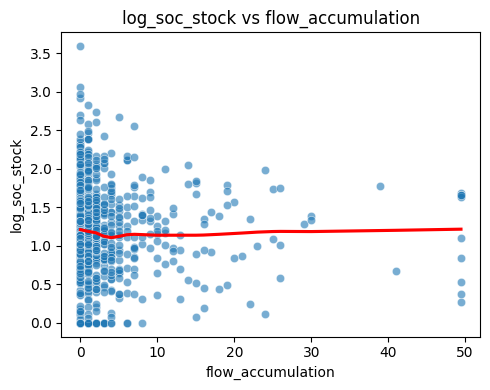

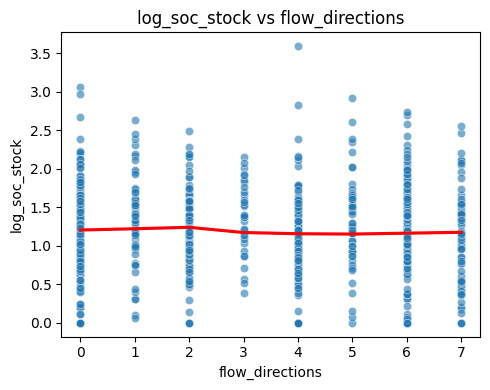

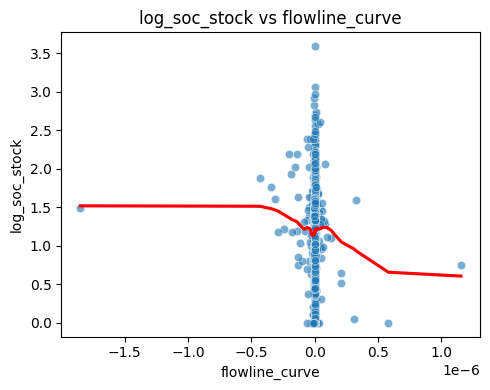

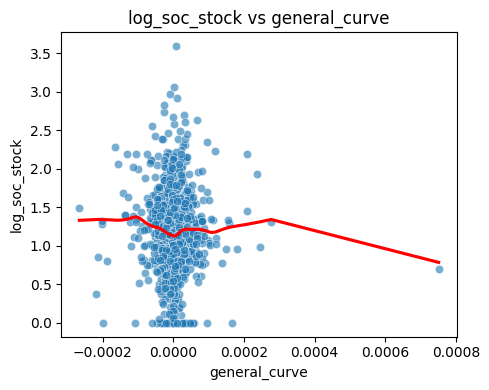

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


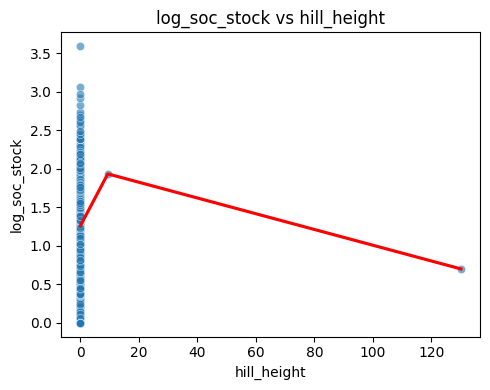

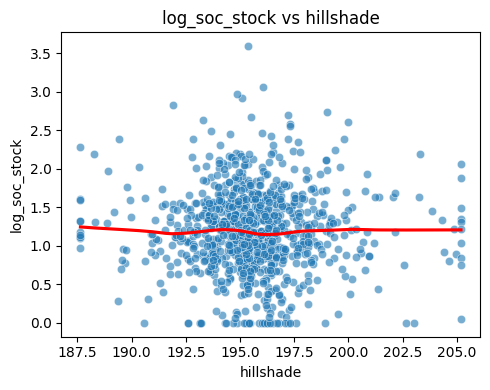

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


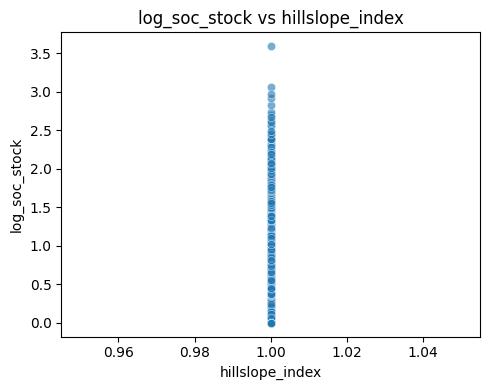

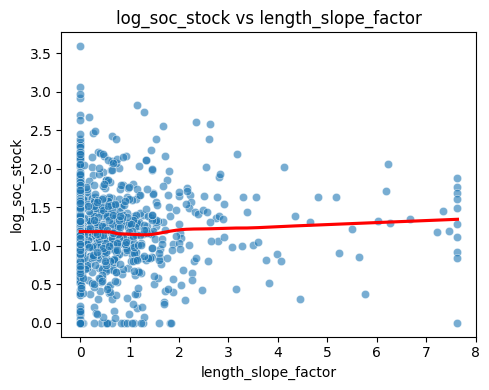

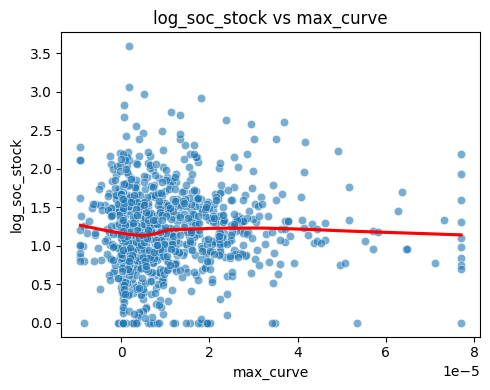

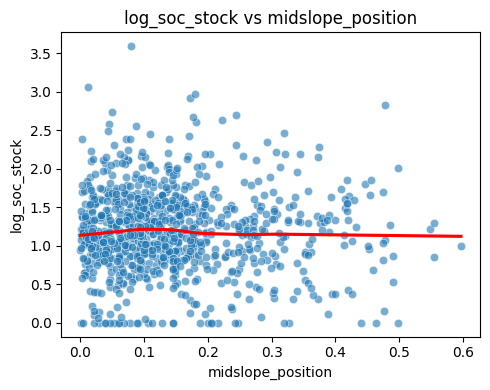

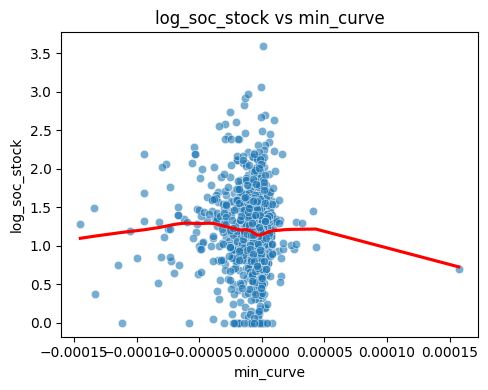

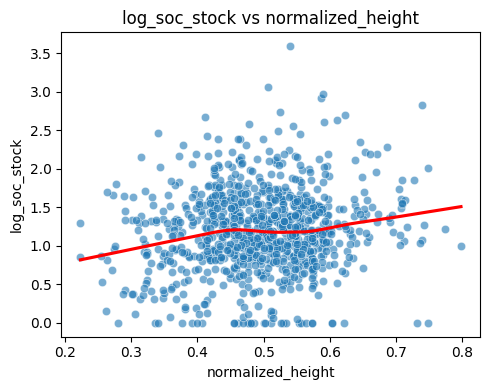

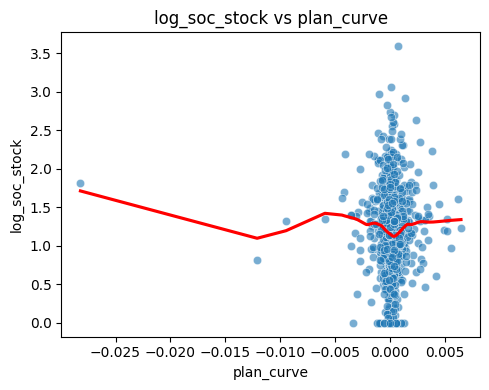

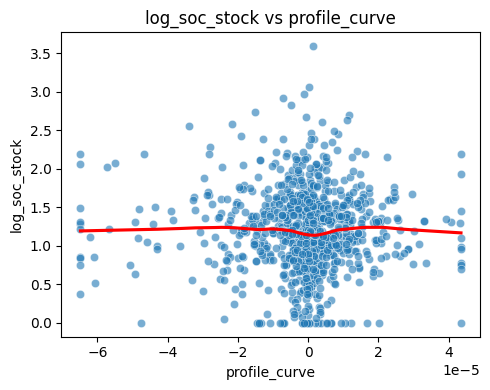

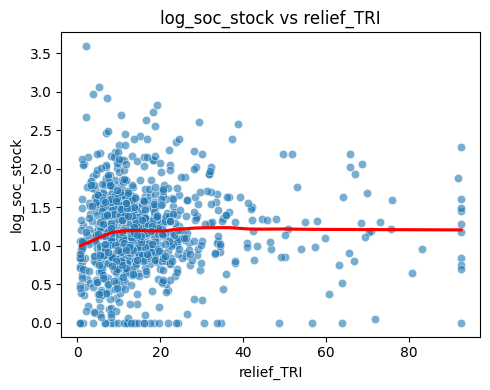

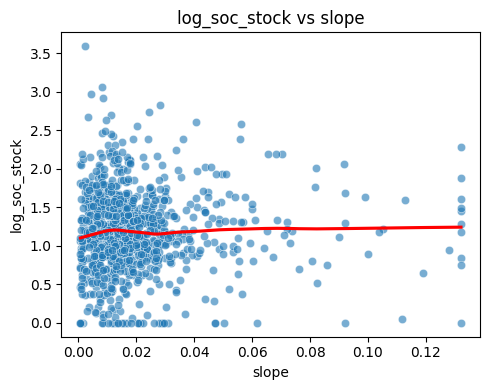

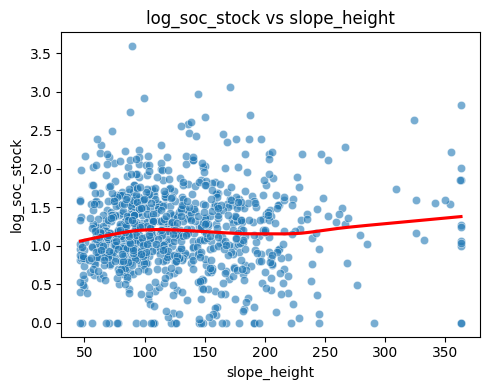

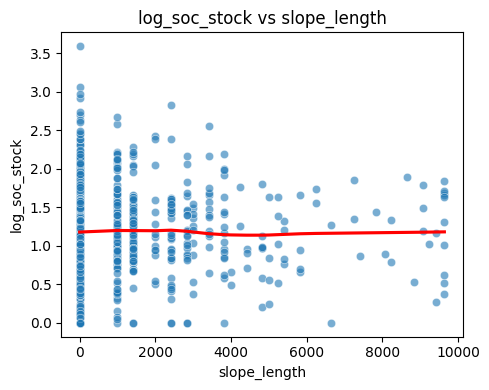

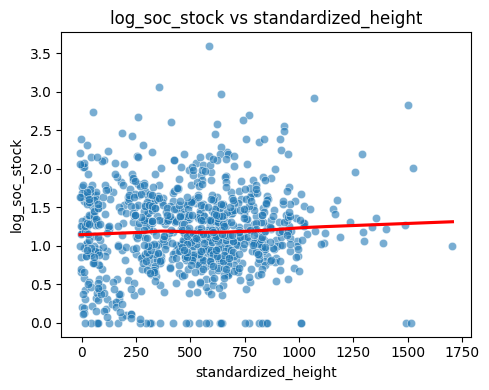

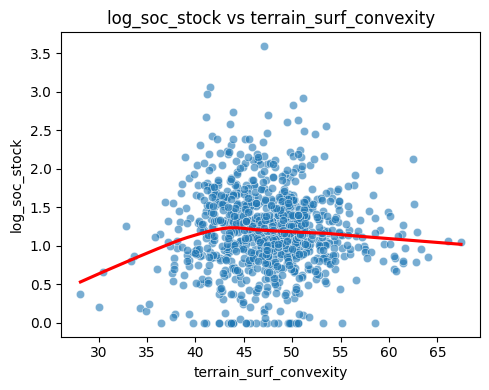

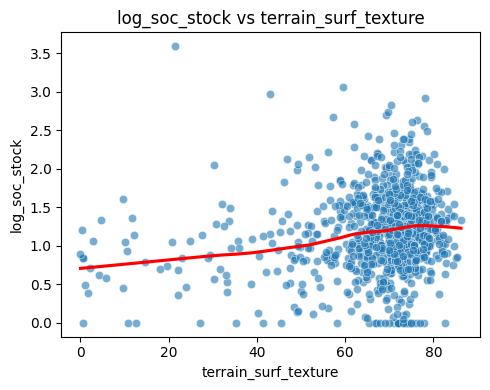

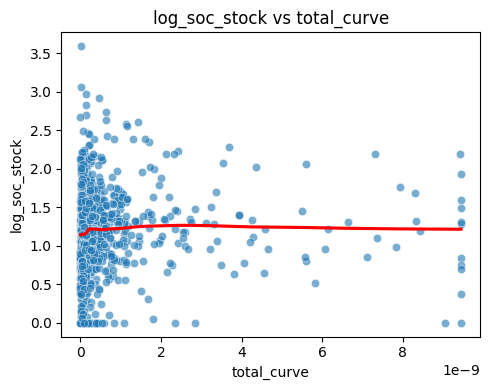

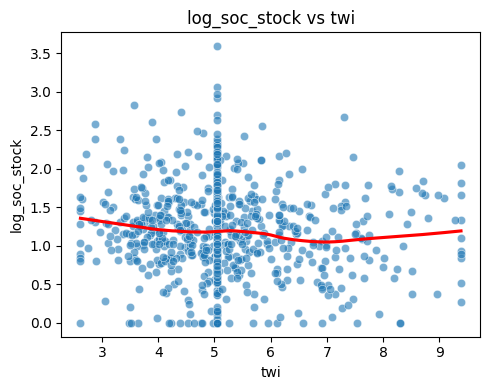

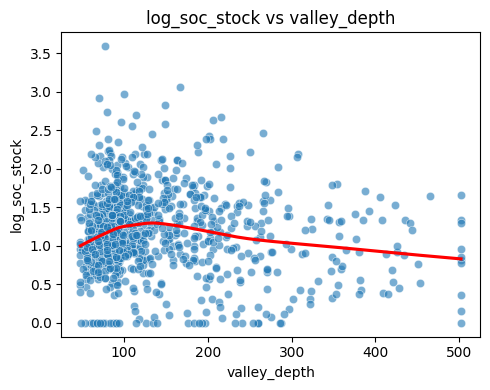

/opt/homebrew/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


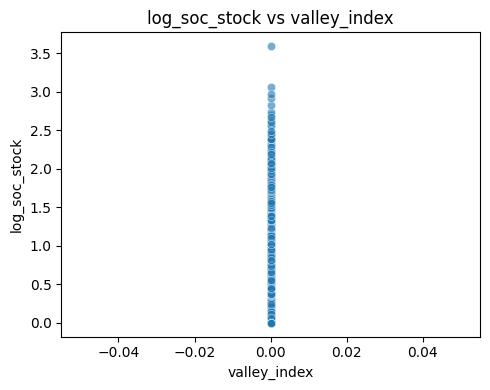

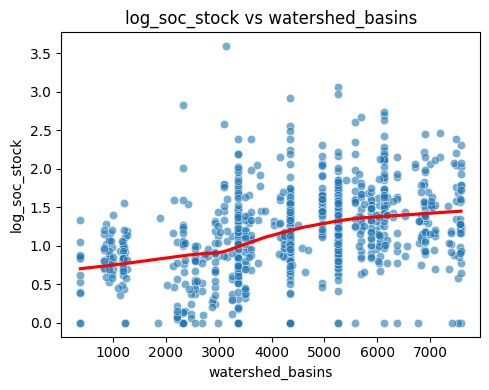

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check which numeric columns exist in df1
numeric_cols_existing = [col for col in numeric_cols if col in df1.columns]

# Create scatter plots vs log_soc_stock
for col in numeric_cols_existing:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=df1, x=col, y='log_soc_stock', alpha=0.6)
    # Optional trend line (smoothed)
    sns.regplot(data=df1, x=col, y='log_soc_stock', scatter=False, lowess=True, color='red')
    
    plt.title(f"log_soc_stock vs {col}")
    plt.xlabel(col)
    plt.ylabel("log_soc_stock")
    plt.tight_layout()
    plt.show()
    plt.close()


In [21]:
# ## checking for nan, 0 and outlier values in columns 


import pandas as pd
import numpy as np

# Select numeric columns
numeric_cols = df1.select_dtypes(include=[np.number]).columns

# Initialize results dictionary
summary = {}

for col in numeric_cols:
    data = df1[col]
    
    # Count NaNs
    n_nan = data.isna().sum()
    
    # Count zeros
    n_zero = (data == 0).sum()
    
    # Detect outliers using 1.5*IQR rule
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    n_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    
    # Store results
    summary[col] = {
        "NaN_count": n_nan,
        "Zero_count": n_zero,
        "Outlier_count": n_outliers
    }

# Convert results to a DataFrame for easy viewing
summary_df = pd.DataFrame(summary).T  # transpose for readability
summary_df = summary_df.sort_values(by="Outlier_count", ascending=False)

# Display results
print(summary_df)


                     NaN_count  Zero_count  Outlier_count
formation                    0           0            239
flowline_curve               0           0            227
twi                          0           0            155
precip_driest_month          0         763            144
litho_value                  0           2            117
...                        ...         ...            ...
MRRTF                        0           0              0
annual_mean_temp            14           0              0
tmin_mean_mean               0           0              0
temp_annual_range           14           0              0
watershed_basins             0           0              0

[86 rows x 3 columns]


In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(summary_df)

                           NaN_count  Zero_count  Outlier_count
formation                          0           0            239
flowline_curve                     0           0            227
twi                                0           0            155
precip_driest_month                0         763            144
litho_value                        0           2            117
landsurface_value                  0           2            114
profile_curve                      0           0            104
total_curve                        0           0            104
plan_curve                         0           0             95
tot_rainfed_1960                   0          60             94
rf_norice_1960                     0          60             94
cropland_1950                      0          75             94
tot_rainfed_1950                   0          80             93
rf_norice_1950                     0          80             93
precip_driest_quarter              0    

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(summary_df)


                           NaN_count  Zero_count  Outlier_count
formation                          0           0            239
flowline_curve                     0           0            227
twi                                0           0            155
precip_driest_month                0         763            144
litho_value                        0           2            117
landsurface_value                  0           2            114
profile_curve                      0           0            104
total_curve                        0           0            104
plan_curve                         0           0             95
tot_rainfed_1960                   0          60             94
rf_norice_1960                     0          60             94
cropland_1950                      0          75             94
tot_rainfed_1950                   0          80             93
rf_norice_1950                     0          80             93
precip_driest_quarter              0    

In [24]:
# Ensure 'year' column exists
if 'year' in df1.columns:
    min_year = df1['year'].min()
    max_year = df1['year'].max()
    print(f"The year range in df1 is: {min_year} – {max_year}")
else:
    print("Column 'year' does not exist in df1.")


The year range in df1 is: 1946.0 – 1967.0


In [25]:
df1[numeric_cols].isna().sum()


log_soc_stock       0
site_info_id        0
X_coord             0
Y_coord             0
year                0
                   ..
total_curve         0
twi                 0
valley_depth        0
valley_index        0
watershed_basins    0
Length: 86, dtype: int64

In [26]:
## dropping rice columns bc not usefule

rice_columns = [
    'rf_norice_1950', 'rf_norice_1960',
    'rf_rice_1950', 'rf_rice_1960',
    'tot_rice_1950', 'tot_rice_1960', 
    'ir_rice_1950', 'ir_rice_1960',
    'ir_norice_1950', 'ir_norice_1960'
]

df1 = df1.drop(columns=rice_columns)


In [27]:
df1.columns

Index(['log_soc_stock', 'site_info_id', 'X_coord', 'Y_coord', 'year',
       'faosoil_id', 'landsurface_value', 'litho_value', 'formation',
       'conv_rangeland_1950', 'conv_rangeland_1960', 'cropland_1950',
       'cropland_1960', 'grazing_1950', 'grazing_1960', 'pasture_1950',
       'pasture_1960', 'rangeland_1950', 'rangeland_1960', 'tot_irri_1950',
       'tot_irri_1960', 'tot_rainfed_1950', 'tot_rainfed_1960',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'max_temp_warmest_month', 'mean_temp_driest_quarter',
       'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter',
       'min_temp_coldest_month', 'precip_coldest_quarter',
       'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
       'precip_warmest_quarter', 'precip_wettest_month',
       'precip_wettest_quarter', 'temp_annual_range', 'temp_seasonality',
       'tmax_mean_mean', 'tmin_mean_mean', 'precip_sum', 'MRRTF', 'MRVBF',
       'aspect', 'as

In [28]:
df1.shape

(907, 76)

### boxplot of log_soc_stock to show outliers

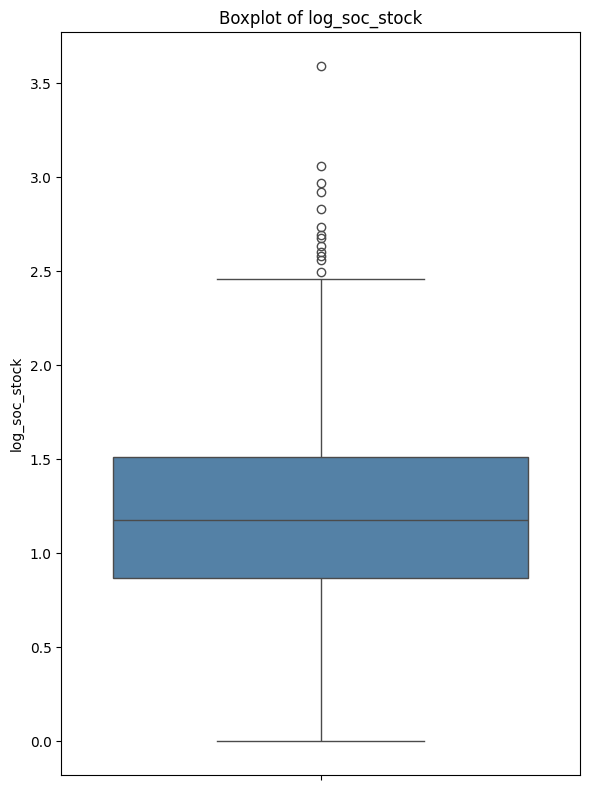

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,8))
sns.boxplot(y=df1['log_soc_stock'], color='steelblue')
plt.title('Boxplot of log_soc_stock')
plt.ylabel('log_soc_stock')
plt.tight_layout()
plt.show()


### save to csv

In [30]:
# # save to CSV
# # ----------------------------
output_path = "/Users/inesschwartz/Desktop/final_training_dataset.csv"
df1.to_csv(output_path, index=False)
print("Ready-to-train dataset saved at:", output_path)

Ready-to-train dataset saved at: /Users/inesschwartz/Desktop/final_training_dataset.csv


In [31]:
df1.columns

Index(['log_soc_stock', 'site_info_id', 'X_coord', 'Y_coord', 'year',
       'faosoil_id', 'landsurface_value', 'litho_value', 'formation',
       'conv_rangeland_1950', 'conv_rangeland_1960', 'cropland_1950',
       'cropland_1960', 'grazing_1950', 'grazing_1960', 'pasture_1950',
       'pasture_1960', 'rangeland_1950', 'rangeland_1960', 'tot_irri_1950',
       'tot_irri_1960', 'tot_rainfed_1950', 'tot_rainfed_1960',
       'mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip',
       'isothermality', 'max_temp_warmest_month', 'mean_temp_driest_quarter',
       'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter',
       'min_temp_coldest_month', 'precip_coldest_quarter',
       'precip_driest_month', 'precip_driest_quarter', 'precip_seasonality',
       'precip_warmest_quarter', 'precip_wettest_month',
       'precip_wettest_quarter', 'temp_annual_range', 'temp_seasonality',
       'tmax_mean_mean', 'tmin_mean_mean', 'precip_sum', 'MRRTF', 'MRVBF',
       'aspect', 'as

## standardize to z score (necessary for regression kriging)

In [32]:
# ## checking continuous columns
# import pandas as pd

# # Example dataframe
# # df1 = pd.read_csv("your_file.csv")  # load your data

# # Parameters
# unique_threshold = 15  # columns with fewer unique numeric values are considered categorical

# # Separate columns by type
# continuous_cols = []
# categorical_cols = []

# for col in df1.columns:
#     if pd.api.types.is_numeric_dtype(df1[col]):
#         n_unique = df1[col].nunique(dropna=True)
#         if n_unique > unique_threshold:
#             continuous_cols.append(col)
#         else:
#             categorical_cols.append(col)
#     else:
#         categorical_cols.append(col)

# # Summary
# print("Continuous columns:")
# print(continuous_cols)
# print("\nCategorical columns:")
# print(categorical_cols)


## redundancy detection

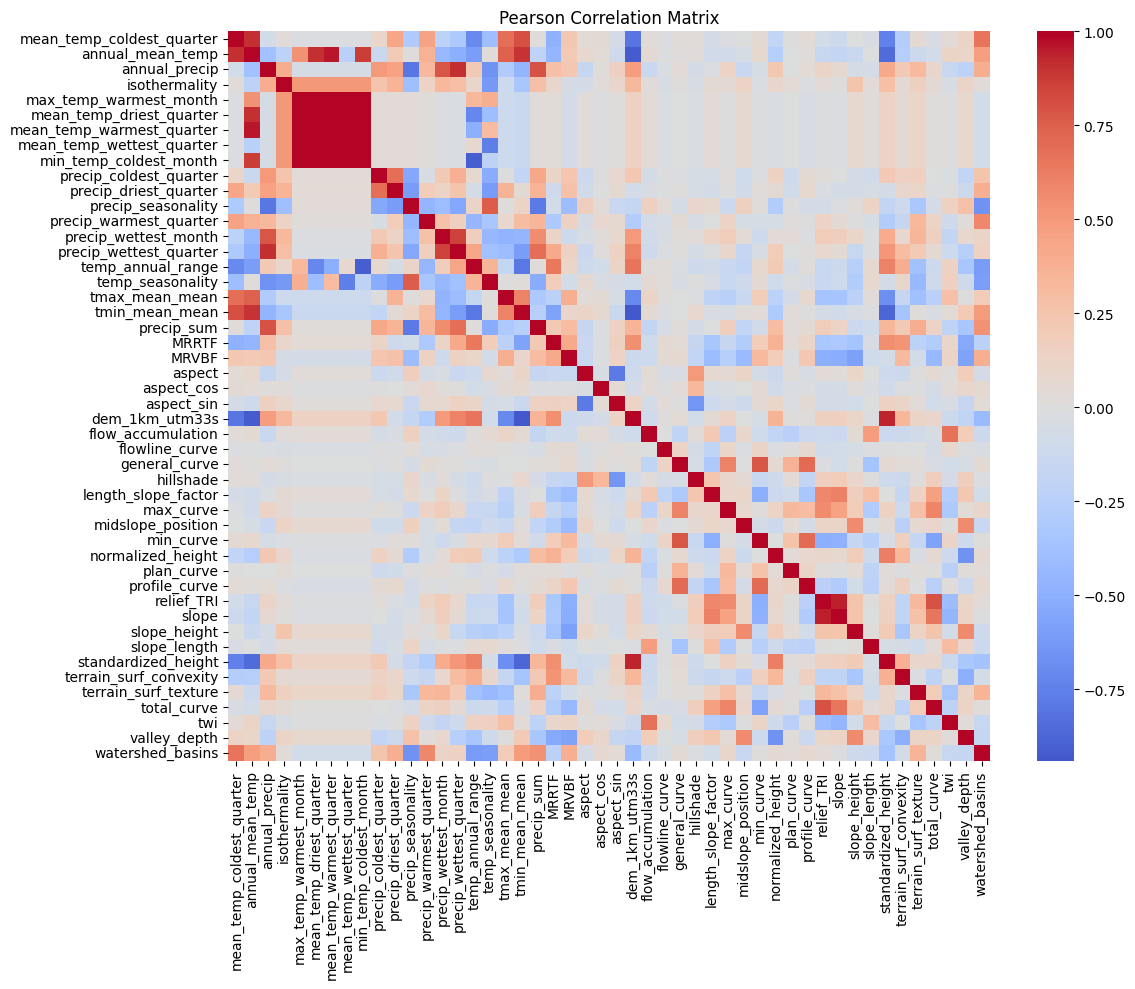

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------------------------
# 1. Define continuous predictors
# -------------------------------------------
continuous_cols = ['mean_temp_coldest_quarter', 'annual_mean_temp', 'annual_precip', 'isothermality', 'max_temp_warmest_month', 'mean_temp_driest_quarter', 'mean_temp_warmest_quarter', 'mean_temp_wettest_quarter', 'min_temp_coldest_month', 'precip_coldest_quarter', 'precip_driest_quarter', 'precip_seasonality', 'precip_warmest_quarter', 'precip_wettest_month', 'precip_wettest_quarter', 'temp_annual_range', 'temp_seasonality', 'tmax_mean_mean', 'tmin_mean_mean', 'precip_sum', 'MRRTF', 'MRVBF', 'aspect', 'aspect_cos', 'aspect_sin', 'dem_1km_utm33s', 'flow_accumulation', 'flowline_curve', 'general_curve', 'hillshade', 'length_slope_factor', 'max_curve', 'midslope_position', 'min_curve', 'normalized_height', 'plan_curve', 'profile_curve', 'relief_TRI', 'slope', 'slope_height', 'slope_length', 'standardized_height', 'terrain_surf_convexity', 'terrain_surf_texture', 'total_curve', 'twi', 'valley_depth', 'watershed_basins']


# -------------------------------------------
# 2. Pearson correlation matrix
# -------------------------------------------
corr = df1[continuous_cols].corr(method="pearson")

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()


In [34]:
# -------------------------------------------
# 3. Variance Inflation Factor (VIF)
# -------------------------------------------
X = df1[continuous_cols].dropna()  # VIF requires no missing values
vif_df = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

print("\nVariance Inflation Factors:")
print(vif_df)



Variance Inflation Factors:
                     variable           VIF
4      max_temp_warmest_month  1.368249e+06
15          temp_annual_range  5.633783e+05
8      min_temp_coldest_month  2.079798e+05
0   mean_temp_coldest_quarter  1.087724e+05
1            annual_mean_temp  8.972582e+04
6   mean_temp_warmest_quarter  8.720289e+04
5    mean_temp_driest_quarter  6.067568e+04
29                  hillshade  5.017356e+03
17             tmax_mean_mean  3.559781e+03
16           temp_seasonality  3.440340e+03
7   mean_temp_wettest_quarter  1.244661e+03
14     precip_wettest_quarter  1.098680e+03
2               annual_precip  1.049631e+03
18             tmin_mean_mean  9.379650e+02
11         precip_seasonality  6.975113e+02
34          normalized_height  5.174432e+02
13       precip_wettest_month  3.524428e+02
25             dem_1km_utm33s  3.195891e+02
3               isothermality  2.688849e+02
41        standardized_height  2.519740e+02
42     terrain_surf_convexity  1.629559e+02
47 

In [35]:
# df_reduced.head()
# df_reduced.to_csv("/Users/inesschwartz/Desktop/model_training_data.csv")

In [36]:
# # Count number of log_soc_stock == 0
# num_zeros = (df_reduced['log_soc_stock'] == 0).sum()
# print("Number of log_soc_stock values equal to 0:", num_zeros)

# # Optionally, view these rows
# zeros_df = df_reduced[df_reduced['log_soc_stock'] == 0]
# print(zeros_df)


## z score standardization of continuous varaiables

In [37]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # ----------------------------
# # 1. Drop zero log_soc_stock
# # ----------------------------
# df_clean = df_reduced[df_reduced['log_soc_stock'] > 0].copy()
# print(f"Rows after dropping zeros: {df_clean.shape[0]}")

# # ----------------------------
# # 2. Identify categorical and continuous variables
# # ----------------------------
# categorical_cols = ['site_info_id', 'profile', 'district', 'X_coord', 'Y_coord',
#                     'landsurface_value', 'formation', 
#                     'litho_value', 'faosoil_id']

# continuous_cols = [c for c in df_clean.columns 
#                    if c not in categorical_cols + ['log_soc_stock']]

# # ----------------------------
# # 3. Standardize continuous covariates (Z-score)
# # ----------------------------
# scaler = StandardScaler()
# df_clean[continuous_cols] = scaler.fit_transform(df_clean[continuous_cols])

# # ----------------------------
# # 4. Ready-to-train dataset
# # ----------------------------
# X = df_clean[continuous_cols + categorical_cols]  # predictors
# y = df_clean['log_soc_stock']                       # target

# print("Predictor matrix shape:", X.shape)
# print("Target vector shape:", y.shape)

# # ----------------------------
# # 5. Optional: save to CSV
# # ----------------------------
# output_path = "/Users/inesschwartz/Desktop/final_training_dataset.csv"
# df_clean.to_csv(output_path, index=False)
# print("Ready-to-train dataset saved at:", output_path)
